In [1]:
directory = '../../output.ibd2'
render='svg'
name='output.ibd2'

In [2]:
from charcoal.utils import CSV_DictHelper
from IPython.display import display, Markdown

summary = CSV_DictHelper(f'{directory}/genome_summary.csv', 'genome')
display(Markdown(f"# charcoal summary report for `{name}`"))


# charcoal summary report for `output.ibd2`

In [3]:
import plotly.graph_objects as go
from charcoal import utils
import collections
import os

In [4]:
# calculate and display some basic statistics
summary = utils.CSV_DictHelper(f'{directory}/genome_summary.csv', 'genome')

all_genomes = set(summary)

n_genomes = len(all_genomes)
no_lineage = set([ k for k in all_genomes if not summary[k].lineage ])
n_no_lineage = len(no_lineage)
all_genomes -= no_lineage

no_genus_contam = set([ k for k in all_genomes if int(summary[k].bad_genus_bp) == 0 ])
n_no_contam = len(no_genus_contam)
all_genomes -= no_genus_contam
contaminated_list = set(all_genomes)
clean_list = set(no_genus_contam)

first_contam = {}
ignore = set()

for rank in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
    n = 0
    for genome in all_genomes:
        bad_bp = int(summary[genome][f'bad_{rank}_bp'])
        if genome in ignore:
            continue
        if bad_bp:
            n += 1
            ignore.add(genome)
            continue
    first_contam[rank] = n
    
def display_genome_list(names_to_show, order_by=None, reverse=True):
    # select only those we want to show
    values = [ summary[k] for k in names_to_show ]
    
    # sort by:
    if order_by:
        values.sort(key=lambda x: int(x[order_by]))
        if reverse: values.reverse()
    else:
        values.sort(key = lambda x: x.genome)
    
    output = []
    for row in values:
        output.append(f"* [`{row.genome}`]({row.genome}.fig.html)")
    
    return "\n".join(output)

def display_no_lineage_list():
    values = [ summary[k] for k in summary if not summary[k].lineage ]
    
    x = []
    for row in values:
        x.append(f"* `{row.genome}` - {row.comment}")
        
    return "\n".join(x)

###### do display

display(Markdown(f"""
# Summary statistics

charcoal examined {n_genomes} total genomes in `{name}`.

{n_no_lineage} could not be analyzed for contamination; see Problem Report, below.

{n_no_contam} had no observed contamination at any taxonomic level down to genus.

Of the remaining {len(contaminated_list)} genomes,
* {first_contam['superkingdom']} had their first observed contamination at **superkingdom**;
* {first_contam['phylum']} had their first observed contamination at **phylum**;
* {first_contam['class']} had their first observed contamination at **class**;
* {first_contam['order']} had their first observed contamination at **order**;
* {first_contam['family']} had their first observed contamination at **family**;
* {first_contam['genus']} had their first observed contamination at **genus**.
"""))



# Summary statistics

charcoal examined 41 total genomes in `output.ibd2`.

3 could not be analyzed for contamination; see Problem Report, below.

8 had no observed contamination at any taxonomic level down to genus.

Of the remaining 30 genomes,
* 0 had their first observed contamination at **superkingdom**;
* 19 had their first observed contamination at **phylum**;
* 0 had their first observed contamination at **class**;
* 7 had their first observed contamination at **order**;
* 0 had their first observed contamination at **family**;
* 4 had their first observed contamination at **genus**.


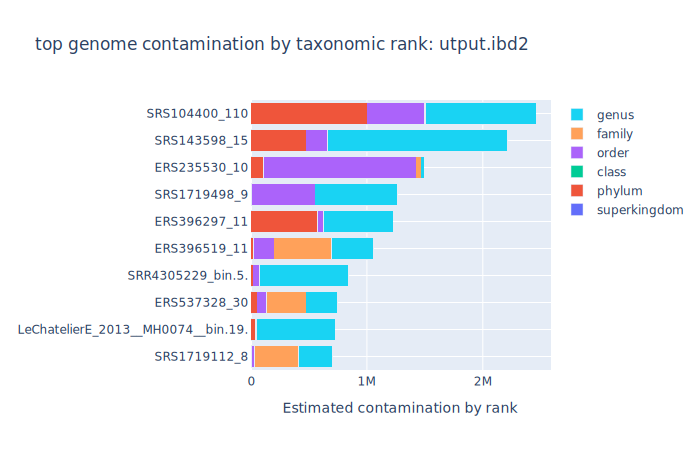

In [5]:
def make_hitlist_data(hit_list_filename, omit_genus=True, num=10):
    hits = utils.CSV_DictHelper(hit_list_filename, 'genome')
    
    endings = '.fna.gz', 'fa.gz', '.fa', '_genomic'
    
    # sort by sum of bad bp at specific rank
    if omit_genus:
        sort_by = 'family_bad_bp'
    else:
        sort_by = 'genus_bad_bp'
    
    # pick off the top num items, sorted by given sort_by
    items = list(hits.rows.items())
    items.sort(key=lambda item: -int(item[1][sort_by]))
    items = items[:num]
    items.reverse()
    
    hitlist_data = collections.defaultdict(list)
    names = hitlist_data['names']
    
    # for each item, retrieve all tax rank bp values
    for name, row in items:
        # clean up names:
        for end in endings:
            if name.endswith(end): name = name[:-len(end)]
        names.append(name)

        last_bp = 0
        for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
            bp = row[f'{key}_bad_bp']
            bp = int(bp)
            values = hitlist_data[key]
            values.append(bp - last_bp)
            last_bp = bp
            
    return hitlist_data

def plot_hitlist(hit_list_filename, omit_genus=True, num=10):
    hitlist_data = make_hitlist_data(hit_list_filename, omit_genus, num)
    
    names = hitlist_data['names']

    barchart_objs = []
    for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
        values = hitlist_data[key]
        if omit_genus and key == 'genus': break
            
        bc_obj = go.Bar(name=key, y=names, x=values, orientation='h')
        barchart_objs.append(bc_obj)
        
    fig = go.Figure(data=barchart_objs)
    title = f'top genome contamination by taxonomic rank: {os.path.dirname(hit_list_filename)[7:]}'
    fig.update_layout(barmode='stack', template='plotly',
                      xaxis_title='Estimated contamination by rank',
                      title=title)

    return fig

fig = plot_hitlist(f'{directory}/hit_list_for_filtering.csv', omit_genus=False)
if not render: render_name = None
else: render_name = render
fig.show(render_name)

In [6]:
display(Markdown(f"""
## Individual contamination reports

(Sorted by summed contamination at genus level.)

{display_genome_list(contaminated_list, 'bad_genus_bp')}

## Problem Report

{n_no_lineage} genomes could not be analyzed for contamination.

{display_no_lineage_list()}

## Analyzed genomes for which no removable contamination was detected

{n_no_contam} genomes had no removable contamination at any taxonomic level down to genus.

(Some of this could be due to cryptic contamination or chimeric contigs. @CTB document.)

{display_genome_list(clean_list)}

"""))


## Individual contamination reports

(Sorted by summed contamination at genus level.)

* [`SRS104400_110.fna.gz`](SRS104400_110.fna.gz.fig.html)
* [`SRS143598_15.fna.gz`](SRS143598_15.fna.gz.fig.html)
* [`ERS235530_10.fna.gz`](ERS235530_10.fna.gz.fig.html)
* [`SRS1719498_9.fna.gz`](SRS1719498_9.fna.gz.fig.html)
* [`ERS396297_11.fna.gz`](ERS396297_11.fna.gz.fig.html)
* [`ERS396519_11.fna.gz`](ERS396519_11.fna.gz.fig.html)
* [`SRR4305229_bin.5.fa.gz`](SRR4305229_bin.5.fa.gz.fig.html)
* [`ERS537328_30.fna.gz`](ERS537328_30.fna.gz.fig.html)
* [`LeChatelierE_2013__MH0074__bin.19.fa.gz`](LeChatelierE_2013__MH0074__bin.19.fa.gz.fig.html)
* [`SRS1719112_8.fna.gz`](SRS1719112_8.fna.gz.fig.html)
* [`SRR5127401_bin.3.fa.gz`](SRR5127401_bin.3.fa.gz.fig.html)
* [`ERS235531_43.fna.gz`](ERS235531_43.fna.gz.fig.html)
* [`ERS537353_12.fna.gz`](ERS537353_12.fna.gz.fig.html)
* [`ERS537235_19.fna.gz`](ERS537235_19.fna.gz.fig.html)
* [`SRS476209_42.fna.gz`](SRS476209_42.fna.gz.fig.html)
* [`ERS608576_22.fna.gz`](ERS608576_22.fna.gz.fig.html)
* [`ERS608524_37.fna.gz`](ERS608524_37.fna.gz.fig.html)
* [`SRS075078_49.fna.gz`](SRS075078_49.fna.gz.fig.html)
* [`SRS1735645_19.fna.gz`](SRS1735645_19.fna.gz.fig.html)
* [`ERS473255_26.fna.gz`](ERS473255_26.fna.gz.fig.html)
* [`GCF_900036035.1_RGNV35913_genomic.fna.gz`](GCF_900036035.1_RGNV35913_genomic.fna.gz.fig.html)
* [`ERS235603_16.fna.gz`](ERS235603_16.fna.gz.fig.html)
* [`SRS1735506_4.fna.gz`](SRS1735506_4.fna.gz.fig.html)
* [`ERS537218_9.fna.gz`](ERS537218_9.fna.gz.fig.html)
* [`ZeeviD_2015__PNP_Main_232__bin.27.fa.gz`](ZeeviD_2015__PNP_Main_232__bin.27.fa.gz.fig.html)
* [`SRS1719577_6.fna.gz`](SRS1719577_6.fna.gz.fig.html)
* [`SRR6028281_bin.3.fa.gz`](SRR6028281_bin.3.fa.gz.fig.html)
* [`LoombaR_2017__SID1050_bax__bin.11.fa.gz`](LoombaR_2017__SID1050_bax__bin.11.fa.gz.fig.html)
* [`VogtmannE_2016__MMRS43563715ST-27-0-0__bin.70.fa.gz`](VogtmannE_2016__MMRS43563715ST-27-0-0__bin.70.fa.gz.fig.html)
* [`SRS294916_20.fna.gz`](SRS294916_20.fna.gz.fig.html)

## Problem Report

3 genomes could not be analyzed for contamination.

* `LiSS_2016__FAT_DON_8-22-0-0__bin.28.fa.gz` - too few hashes in major lineage; f_major < 20%. provide a lineage for this genome.
* `GCF_001405615.1_13414_6_47_genomic.fna.gz` - found exact match: GCF_001405615 s__Agathobacter faecis. but no provided lineage! cannot analyze.
* `GCF_000508885.1_ASM50888v1_genomic.fna.gz` - found exact match: GCF_000508885 s__Flavonifractor sp000508885. but no provided lineage! cannot analyze.

## Analyzed genomes for which no removable contamination was detected

8 genomes had no removable contamination at any taxonomic level down to genus.

(Some of this could be due to cryptic contamination or chimeric contigs. @CTB document.)

* [`GCF_000371685.1_Clos_bolt_90B3_V1_genomic.fna.gz`](GCF_000371685.1_Clos_bolt_90B3_V1_genomic.fna.gz.fig.html)
* [`LiJ_2014__O2.UC28-1__bin.61.fa.gz`](LiJ_2014__O2.UC28-1__bin.61.fa.gz.fig.html)
* [`NielsenHB_2014__MH0094__bin.44.fa.gz`](NielsenHB_2014__MH0094__bin.44.fa.gz.fig.html)
* [`QinJ_2012__CON-091__bin.20.fa.gz`](QinJ_2012__CON-091__bin.20.fa.gz.fig.html)
* [`SRR5558047_bin.10.fa.gz`](SRR5558047_bin.10.fa.gz.fig.html)
* [`SRS103987_37.fna.gz`](SRS103987_37.fna.gz.fig.html)
* [`VatanenT_2016__G80445__bin.9.fa.gz`](VatanenT_2016__G80445__bin.9.fa.gz.fig.html)
* [`XieH_2016__YSZC12003_37172__bin.63.fa.gz`](XieH_2016__YSZC12003_37172__bin.63.fa.gz.fig.html)

